[{'Tweet': 'RT @ElAmerican_: #Election2020 \n\nElectoral votes so far: \n\n🔴 Trump, 214 votes\n\n🔵 Biden, 253 votes \n\n#Elections', 'Timestamp': datetime.datetime(2020, 11, 5, 0, 26, 13)}, {'Tweet': 'I’m less concerned with Trump winning—I think Biden pulls it out. What I am concerned about is Biden winning legiti… https://t.co/B9ZqpjCqnc', 'Timestamp': datetime.datetime(2020, 11, 5, 0, 26, 13)}, {'Tweet': 'Trump is starting to destroy the fabrics of American democracy.\n#Election2020', 'Timestamp': datetime.datetime(2020, 11, 5, 0, 26, 13)}, {'Tweet': "RT @TruthsOverTrump: BREAKING NEWS 📰\n\nDonald Trump is a flight risk. Putin is so upset that #TrumpIsALoser that he won't let Trump come to…", 'Timestamp': datetime.datetime(2020, 11, 5, 0, 26, 13)}, {'Tweet': "RT @NPRItsBeenAMin: 📣 NEW EPISODE 📣\n \n@samsanders chats with The Atlantic staff writer @mckaycoppins about #Election2020 results and what's…", 'Timestamp': datetime.datetime(2020, 11, 5, 0, 26, 13)}, {'Tweet': 'RT @SiriusXMPa

polarity                  subjectivity                    
           mean amax amin median         mean amax amin    median
Trump                                                            
1      0.064857  1.0 -1.0    0.0     0.285472  1.0  0.0  0.066667

polarity                  subjectivity                 
           mean amax amin median         mean amax amin median
Biden                                                         
1      0.144428  1.0 -1.0    0.0       0.3481  1.0  0.0    0.4

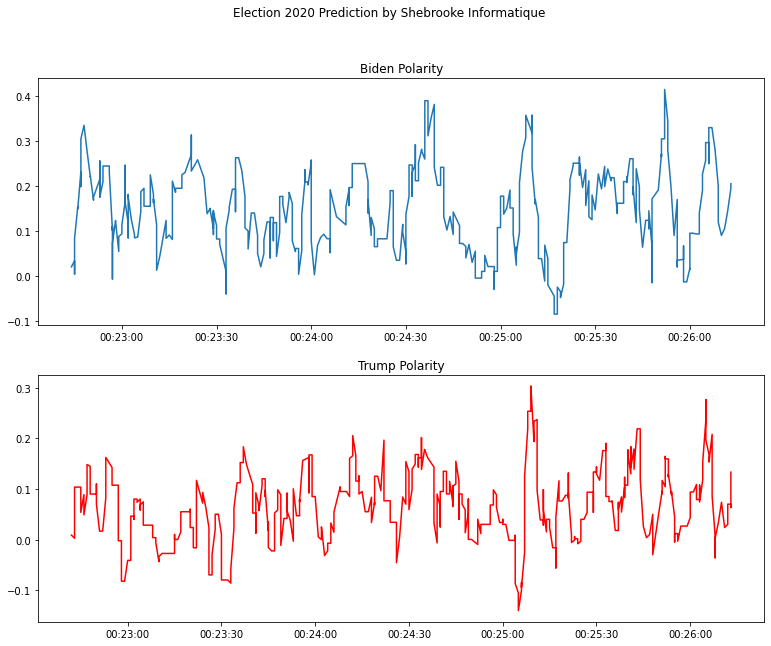

In [8]:
# Import tweepy to work with the twitter API
import tweepy as tw

# Import numpy and pandas to work with dataframes
import numpy as np
import pandas as pd

# Import seaborn and matplotlib for viz
from matplotlib import pyplot as plt

consumer_key="U9PZprvQsTHlEAhr87oyc0mhY"
consumer_secret="KphaxCtCh5XDw0t4e4JCJ7pv3R7lPnRQ10PYgwEkEPJPdo0UX0"
access_token="1084536220141740035-ywa1yvmxzPni8Kt8pjmxVP07gmz253"
access_token_secret="kk2CQVGWynjJfGsXgZsQiXRuBIHWfC8gHVZa5DcQtbgLg"

# Authenticate
auth = tw.OAuthHandler(consumer_key, consumer_secret)
# Set Tokens
auth.set_access_token(access_token, access_token_secret)
# Instantiate API
api = tw.API(auth, wait_on_rate_limit=True)

hashtag = "#Election2020"
query = tw.Cursor(api.search, q=hashtag).items(2500)
tweets = [{'Tweet':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
print(tweets)

df = pd.DataFrame.from_dict(tweets)
df.head()

trump_handle = ['DonaldTrump', 'Donald Trump', 'Donald', 'Trump', 'Trump\'s']
biden_handle = ['JoeBiden', 'Joe Biden', 'Joe', 'Biden', 'Biden\'s']

def identify_subject(tweet, refs):
    flag = 0 
    for ref in refs:
        if tweet.find(ref) != -1:
            flag = 1
    return flag

df['Trump'] = df['Tweet'].apply(lambda x: identify_subject(x, trump_handle)) 
df['Biden'] = df['Tweet'].apply(lambda x: identify_subject(x, biden_handle))
df.head(10)

# Import stopwords
import nltk
from nltk.corpus import stopwords

# Import textblob
from textblob import Word, TextBlob

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['RT', '#Election2020']

def preprocess_tweets(tweet, custom_stopwords):
    processed_tweet = tweet
    processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

df['Processed Tweet'] = df['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.head()

print('Base review\n', df['Tweet'][0])
print('\n------------------------------------\n')
print('Cleaned and lemmatized review\n', df['Processed Tweet'][0])

# Calculate polarity
df['polarity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
df[['Processed Tweet', 'Biden', 'Trump', 'polarity', 'subjectivity']].head()

display(df[df['Trump']==1][['Trump','polarity','subjectivity']].groupby('Trump').agg([np.mean, np.max, np.min, np.median]))
display(df[df['Biden']==1][['Biden','polarity','subjectivity']].groupby('Biden').agg([np.mean, np.max, np.min, np.median]))

biden = df[df['Biden']==1][['Timestamp', 'polarity']]
biden = biden.sort_values(by='Timestamp', ascending=True)
biden['MA Polarity'] = biden.polarity.rolling(10, min_periods=10).mean()

trump = df[df['Trump']==1][['Timestamp', 'polarity']]
trump = trump.sort_values(by='Timestamp', ascending=True)
trump['MA Polarity'] = trump.polarity.rolling(10, min_periods=10).mean()

trump.head()
biden.head()

repub = 'red'
demo = 'blue'
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(biden['Timestamp'], biden['MA Polarity'])
axes[0].set_title("\n".join(["Biden Polarity"]))
axes[1].plot(trump['Timestamp'], trump['MA Polarity'], color='red')
axes[1].set_title("\n".join(["Trump Polarity"]))

fig.suptitle("\n".join(["Election 2020 Prediction by Shebrooke Informatique"]), y=0.98)

plt.show()